In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

LINE_WIDTH = 2
# sns.set()

In [17]:
def avrg(curve, weight):
    end = curve.shape[1] # min(c.BUDGET, curve.shape[1])
    stdCurve = curve[1, :end]; curve = curve[0, :end]
    avrg_mean = []
    avrg_std = []
    moving_mean = curve[0]
    moving_std = stdCurve[0]
    for i in range(1, len(curve)):
        moving_mean = weight * moving_mean + (1 - weight) * curve[i]
        moving_std = weight * moving_std + (1 - weight) * stdCurve[i]
        avrg_mean.append(moving_mean)
        avrg_std.append(moving_std)
    return np.array(avrg_mean), np.array(avrg_std)

In [18]:
def plot_upper_bound(dataset, budget, color, alpha=0.8, percentile=0.98):
    file = os.path.join("/home/thorben/phd/projects/al_benchmark/runs", dataset, "UpperBound/accuracies.csv")
    all_runs = pd.read_csv(file, header=0, index_col=0)
    mean = np.mean(all_runs.values, axis=1)
    mean_percentile = percentile * mean
    mean = [float(mean)]*budget
    mean_percentile = [float(mean_percentile)]*budget
    plt.plot(range(budget), mean, label="upper bound", linewidth=LINE_WIDTH, c=color, alpha=alpha)
    plt.plot(range(budget), mean_percentile, label="98% Percentile", linewidth=1, linestyle='--', c=color, alpha=0.6)

In [19]:
def plot_benchmark(path, color, display_name, smoothing_weight=0.0, alpha=0.8, plot_std=True):
    file = os.path.join("/home/thorben/phd/projects/al_benchmark/runs", path, "accuracies.csv")
    all_runs = pd.read_csv(file, header=0, index_col=0)
    mean = np.mean(all_runs.values, axis=1)
    std = np.std(all_runs.values, axis=1)
    curve = np.stack([mean, std])
    auc = round(sum(curve[0]) / len(curve[0]), 3)
    avrg_curve, std_curve = avrg(curve, smoothing_weight)
    fullName = f"{display_name} auc {auc}"
    x = np.arange(len(avrg_curve))
    if plot_std:
        plt.fill_between(x, avrg_curve-std_curve, avrg_curve+std_curve, alpha=0.5, facecolor=color)
    plt.plot(x, avrg_curve, label=fullName, linewidth=LINE_WIDTH, c=color, alpha=alpha)
    return len(x)

# Splice

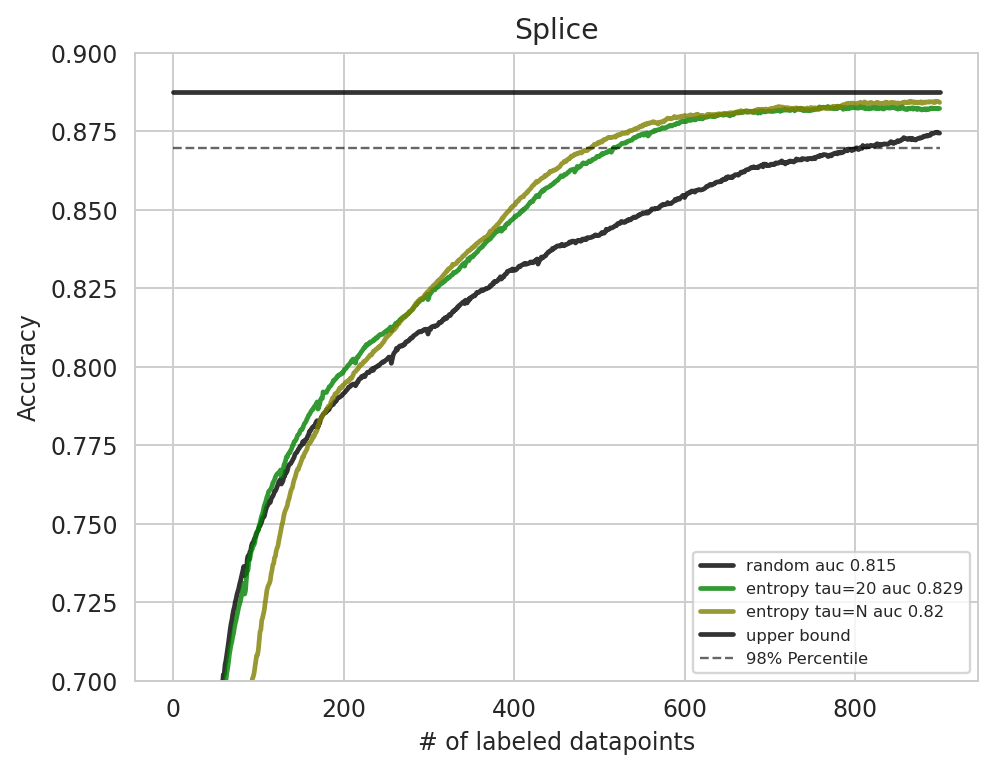

In [20]:
plt.figure(dpi=170)
plot_std = False

# plot_benchmark("Splice/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("Splice/RandomAgent", "black", display_name="random", plot_std=plot_std)
# plot_benchmark("Splice/MarginScore", "navy", display_name="margin", plot_std=plot_std)
plot_benchmark("Splice/ShannonEntropy", "green", display_name="entropy tau=20", plot_std=plot_std)
plot_benchmark("Splice/ShannonEntropy_1000", "olive", display_name="entropy tau=N", plot_std=plot_std)
# plot_benchmark("Splice/ShannonEntropy_200", "olive", display_name="entropy", plot_std=plot_std)
# plot_benchmark("Splice/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
# plot_benchmark('Splice/SAR_23_01_12', 'orange', display_name='agent_01_12', plot_std=plot_std)
# plot_benchmark('Splice/SAR_23_01_16', 'yellow', display_name='agent_01_16', plot_std=plot_std)
plot_upper_bound('Splice', 900, "black")

plt.title('Splice')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
plt.ylim(0.7, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# DNA

In [21]:
plot_std = False
plt.figure(dpi=170)
# plot('../baselines/dna/oracle_finetuning.npy', 'orange', display_name='oracle_finetuning', weight=0.6)

plot_benchmark('DNA/Oracle', 'red', display_name='oracle', plot_std=plot_std)
plot_benchmark("DNA/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("DNA/MarginScore", "navy", display_name="margin", plot_std=plot_std)
plot_benchmark("DNA/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("DNA/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_upper_bound("DNA", 600, "black")

plt.title('DNA')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
plt.ylim(0.8, 0.95)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/thorben/phd/projects/al_benchmark/runs/DNA/Oracle/accuracies.csv'

<Figure size 1088x816 with 0 Axes>

# Cifar10

In [ ]:
plot_std = False
plt.figure(dpi=170)

plot_benchmark("Cifar10/RandomAgentDrops", "black", display_name="random", plot_std=plot_std)
plot_benchmark("Cifar10/RandomAgent", "blue", display_name="random", plot_std=plot_std)
plot_upper_bound("Cifar10", 2000, "black")

plt.title('Cifar10')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.8, 0.95)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()